# JOSS publication figures creator
This script will create the figures that are used in the JOSS publication of the Metob-toolkit.

In [1]:
#!pip install MetObs-toolkit
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None} #else the legend is cutoff in ipython inline plots

In [2]:
import logging
import math
import os
import sys
import time
from pathlib import Path

import metobs_toolkit
print(f'Metobs_toolkit version: v{metobs_toolkit.__version__}')

import matplotlib.pyplot as plt
import pandas as pd


Metobs_toolkit version: v0.4.7


## Creation of the Dataset

In [3]:
datadf = pd.read_csv(metobs_toolkit.demo_datafile, sep=';')
metadf = pd.read_csv(metobs_toolkit.demo_metadatafile, sep=',')

# Subset to regio ghent
ghent_stations = [ 'vlinder24', 'vlinder25', 'vlinder05', 'vlinder27',
                  'vlinder02', 'vlinder01', 'vlinder28']


datadf = datadf[datadf['Vlinder'].isin(ghent_stations)]
metadf = metadf[metadf['Vlinder'].isin(ghent_stations)]

# subset period
datadf['dummy_dt'] = datadf['Datum'] + datadf['Tijd (UTC)']
datadf['dummy_dt'] = pd.to_datetime(datadf['dummy_dt'], format='%Y-%m-%d%H:%M:%S')

#Subset to period
from datetime import datetime
startdt = datetime(2022, 9, 1)
enddt = datetime(2022, 9, 10)
datadf = datadf[(datadf['dummy_dt'] >= startdt) & (datadf['dummy_dt'] <= enddt)]
datadf = datadf.drop(columns=['dummy_dt'])

# Inducing outliers as demo
datadf = datadf.drop(index=datadf.iloc[180:200, :].index.tolist())

# save in paper folder
folder = os.path.abspath('')
datadf.to_csv(os.path.join(folder, 'datafile.csv'))
metadf.to_csv(os.path.join(folder, 'metadatafile.csv'))

#Importing raw data
dataset = metobs_toolkit.Dataset()

dataset.import_data_from_file(input_data_file=os.path.join(folder, 'datafile.csv'),
                        input_metadata_file=os.path.join(folder, 'metadatafile.csv'),
                        template_file=metobs_toolkit.demo_template)

Unnamed: 0 is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following columns are present in the data file, but not in the template! They are skipped!
 ['Rukwind', 'Neerslagintensiteit', 'Luchtdruk_Zeeniveau', 'Neerslagsom', 'Globe Temperatuur', 'Luchtdruk', 'Unnamed: 0']
The following columns are found in the metadata, but not in the temp

## Timeseries for each station

The present gaps are removed, new gaps are constructed for humidity data of station vlinder01..
The present gaps are removed, new gaps are constructed for wind_speed data of station vlinder01..
The present gaps are removed, new gaps are constructed for temp data of station vlinder01..
The present gaps are removed, new gaps are constructed for wind_direction data of station vlinder01..


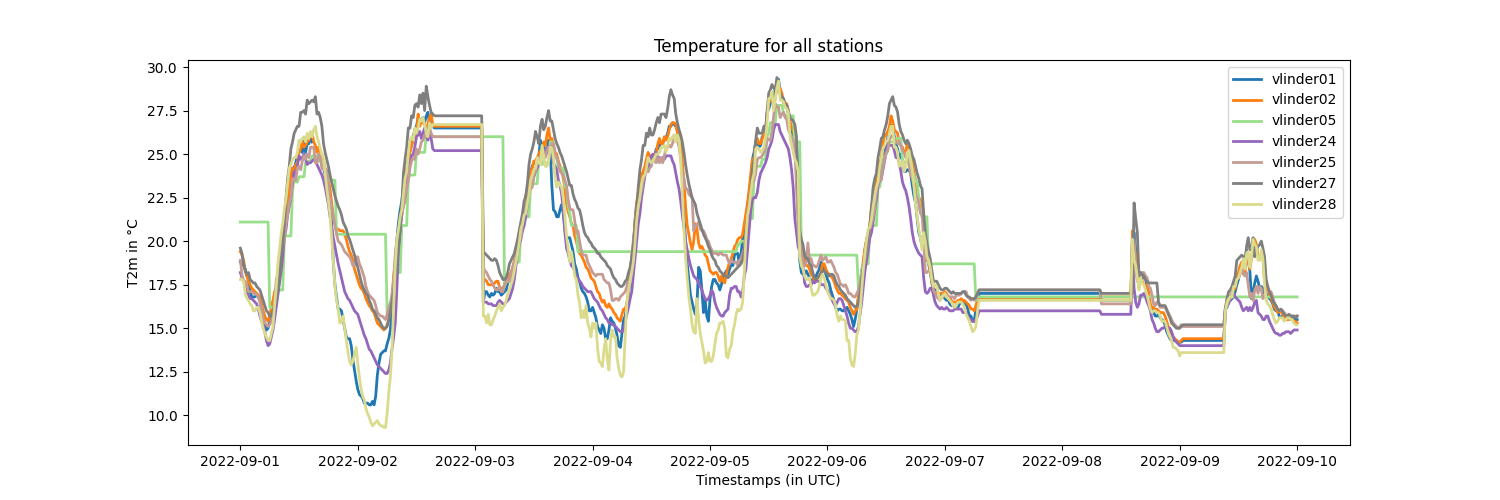

In [4]:
#1. Coarsen resolution and apply quality control with non-defaults as demonstration
dataset.resample(target_freq='20min')

ax1 = dataset.make_plot(colorby='station', title='Temperature for all stations')

#translate axes
ax1.set_ylabel('T2m in °C')
plt.show()

## Timeseries with quality control labels

/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


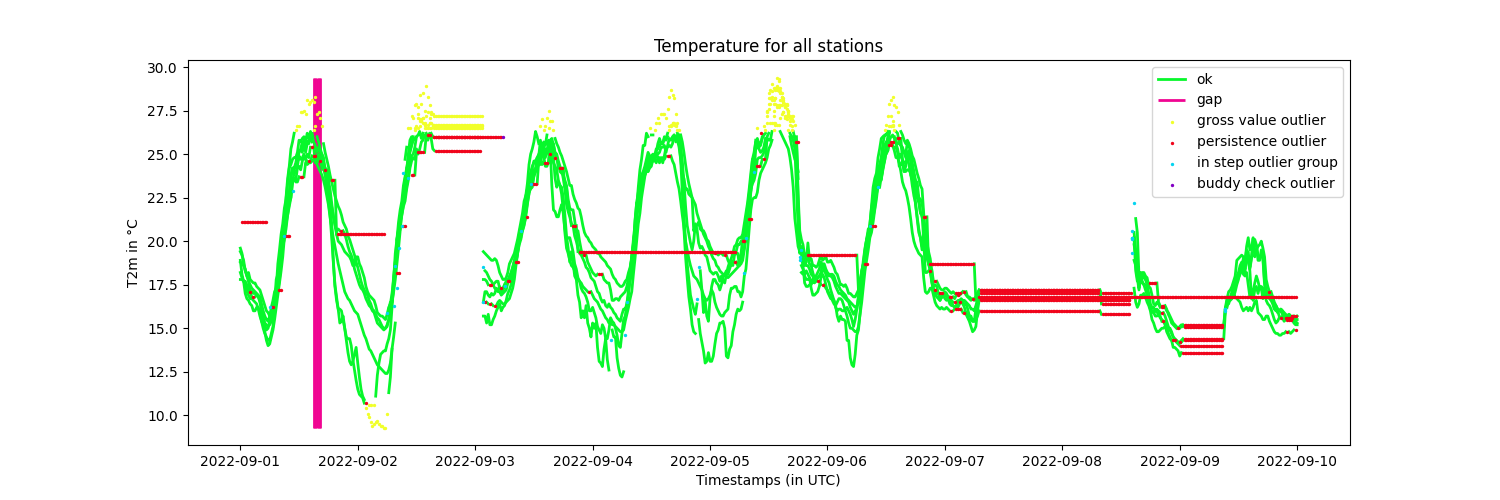

In [5]:

#1. gross value check
target = 'temp'
dataset.gross_value_check(
            target_obstype=target,
            lower_threshold=10.7,
            upper_threshold=26.3)

#2. persistence check
dataset.persistence_check(
            target_obstype=target,
            timewindow='60min',
            min_records_per_window=3)

#3. repetitions check
dataset.repetitions_check(
            target_obstype=target,
            max_N_repetitions=5
)

#4. repetitions check
dataset.step_check(
            target_obstype=target,
            max_increase_per_second = 5.0 / 3600.0, #depends on standard unit! 
            max_decrease_per_second = -10.0 / 3600.0) #depends on standard unit! 

#5. window variation check
dataset.window_variation_check(
            target_obstype=target,
            timewindow='60min',
            min_records_per_window=3,
            max_increase_per_second=8.0 / 3600.0, #depends on standard unit! 
            max_decrease_per_second = -10.0 / 3600.0, #depends on standard unit! 
)
#6. buddy check
dataset.buddy_check(
        target_obstype=target,
        #main check settings
        spatial_buddy_radius=15000, #15km defenition of buddy radius
        spatial_z_threshold=2.0, #outlier threshold
        #requirements
        min_sample_size=5,
        max_alt_diff=None,  # Maximum elevation difference between stations
        N_iter=3, #Number of iterations
        instantaneous_tolerance='4min', #Max timestamp tolerance for 'at the same time'
        lapserate=None, #Specify the variation with altitude, if None no correction is applied
        min_std=1.0,  # Minimum standart deviation
)

# Create the plot
ax2 = dataset.make_plot(colorby='label')
#translate axes
ax2.set_title('Temperature for all stations')
ax2.set_ylabel('T2m in °C')

plt.show()

## Fill gaps and plot timeseries of Vlinder28

In [6]:
# 1. Convert the outliers to gaps
dataset.convert_outliers_to_gaps()

# 2. Extract ERA5 temperature timeseries at the location of the stations
era5_manager = metobs_toolkit.default_GEE_datasets['ERA5-land']
#Extract the timeseries 
era5_temp = dataset.get_gee_timeseries_data(
            geedynamicdatasetmanager=era5_manager, #The datasetmanager to use
            target_obstypes=['temp'], #the observationtypes to extract, must be knonw modelobstypes
            get_all_bands=False, #If true, all bands are extracted (but not stored in the stations if the band is unknwown)
            force_direct_transfer=True,
            )


End of modeltimeseries is not compatible with the end of the gap (plus the trailing period size): 2022-09-10 00:00:00+00:00 >= (2022-09-09 08:40:00+00:00 + 1 days 00:00:00) == False.
End of modeltimeseries is not compatible with the end of the gap (plus the trailing period size): 2022-09-10 00:00:00+00:00 >= (2022-09-09 08:40:00+00:00 + 1 days 00:00:00) == False.
Start of modeltimeseries is not compatible with the start of the gap (minus the leading period size): 2022-09-01 00:00:00+00:00 <= (2022-09-01 20:00:00+00:00 - 1 days 00:00:00) == False.
End of modeltimeseries is not compatible with the end of the gap (plus the trailing period size): 2022-09-10 00:00:00+00:00 >= (2022-09-09 08:40:00+00:00 + 1 days 00:00:00) == False.
End of modeltimeseries is not compatible with the end of the gap (plus the trailing period size): 2022-09-10 00:00:00+00:00 >= (2022-09-09 08:40:00+00:00 + 1 days 00:00:00) == False.
End of modeltimeseries is not compatible with the end of the gap (plus the traili

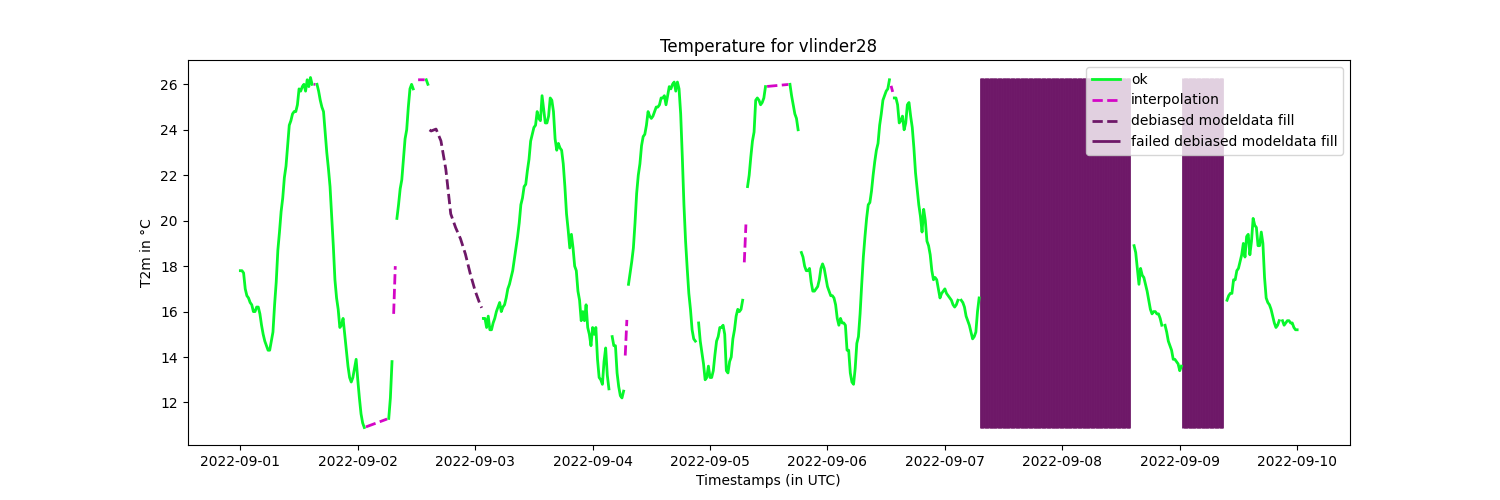

In [7]:
# 3. Fill the gaps (For shorter gaps we use interpolation, and for longer gaps we use debiased ERA5 temperature).

dataset.interpolate_gaps(target_obstype='temp',
                         method='time',
                         max_gap_duration_to_fill=pd.Timedelta('6h'),
                         overwrite_fill=False,
)

# 4. Fill the gaps with ERA5 data
dataset.fill_gaps_with_debiased_modeldata(target_obstype='temp',
                                          leading_period_duration='24h',
                                          min_leading_records_total=3,
                                          trailing_period_duration='24h',
                                          min_trailing_records_total=3,
                                          overwrite_fill=False) #Do not overwrite the interpolated small gaps

# 4. Make plot (of single station for clearity)
ax3 = dataset.get_station('vlinder28').make_plot(colorby='label')

#translate axes
ax3.set_title('Temperature for vlinder28')
ax3.set_ylabel('T2m in °C')

plt.show()

## Diurnal Analysis

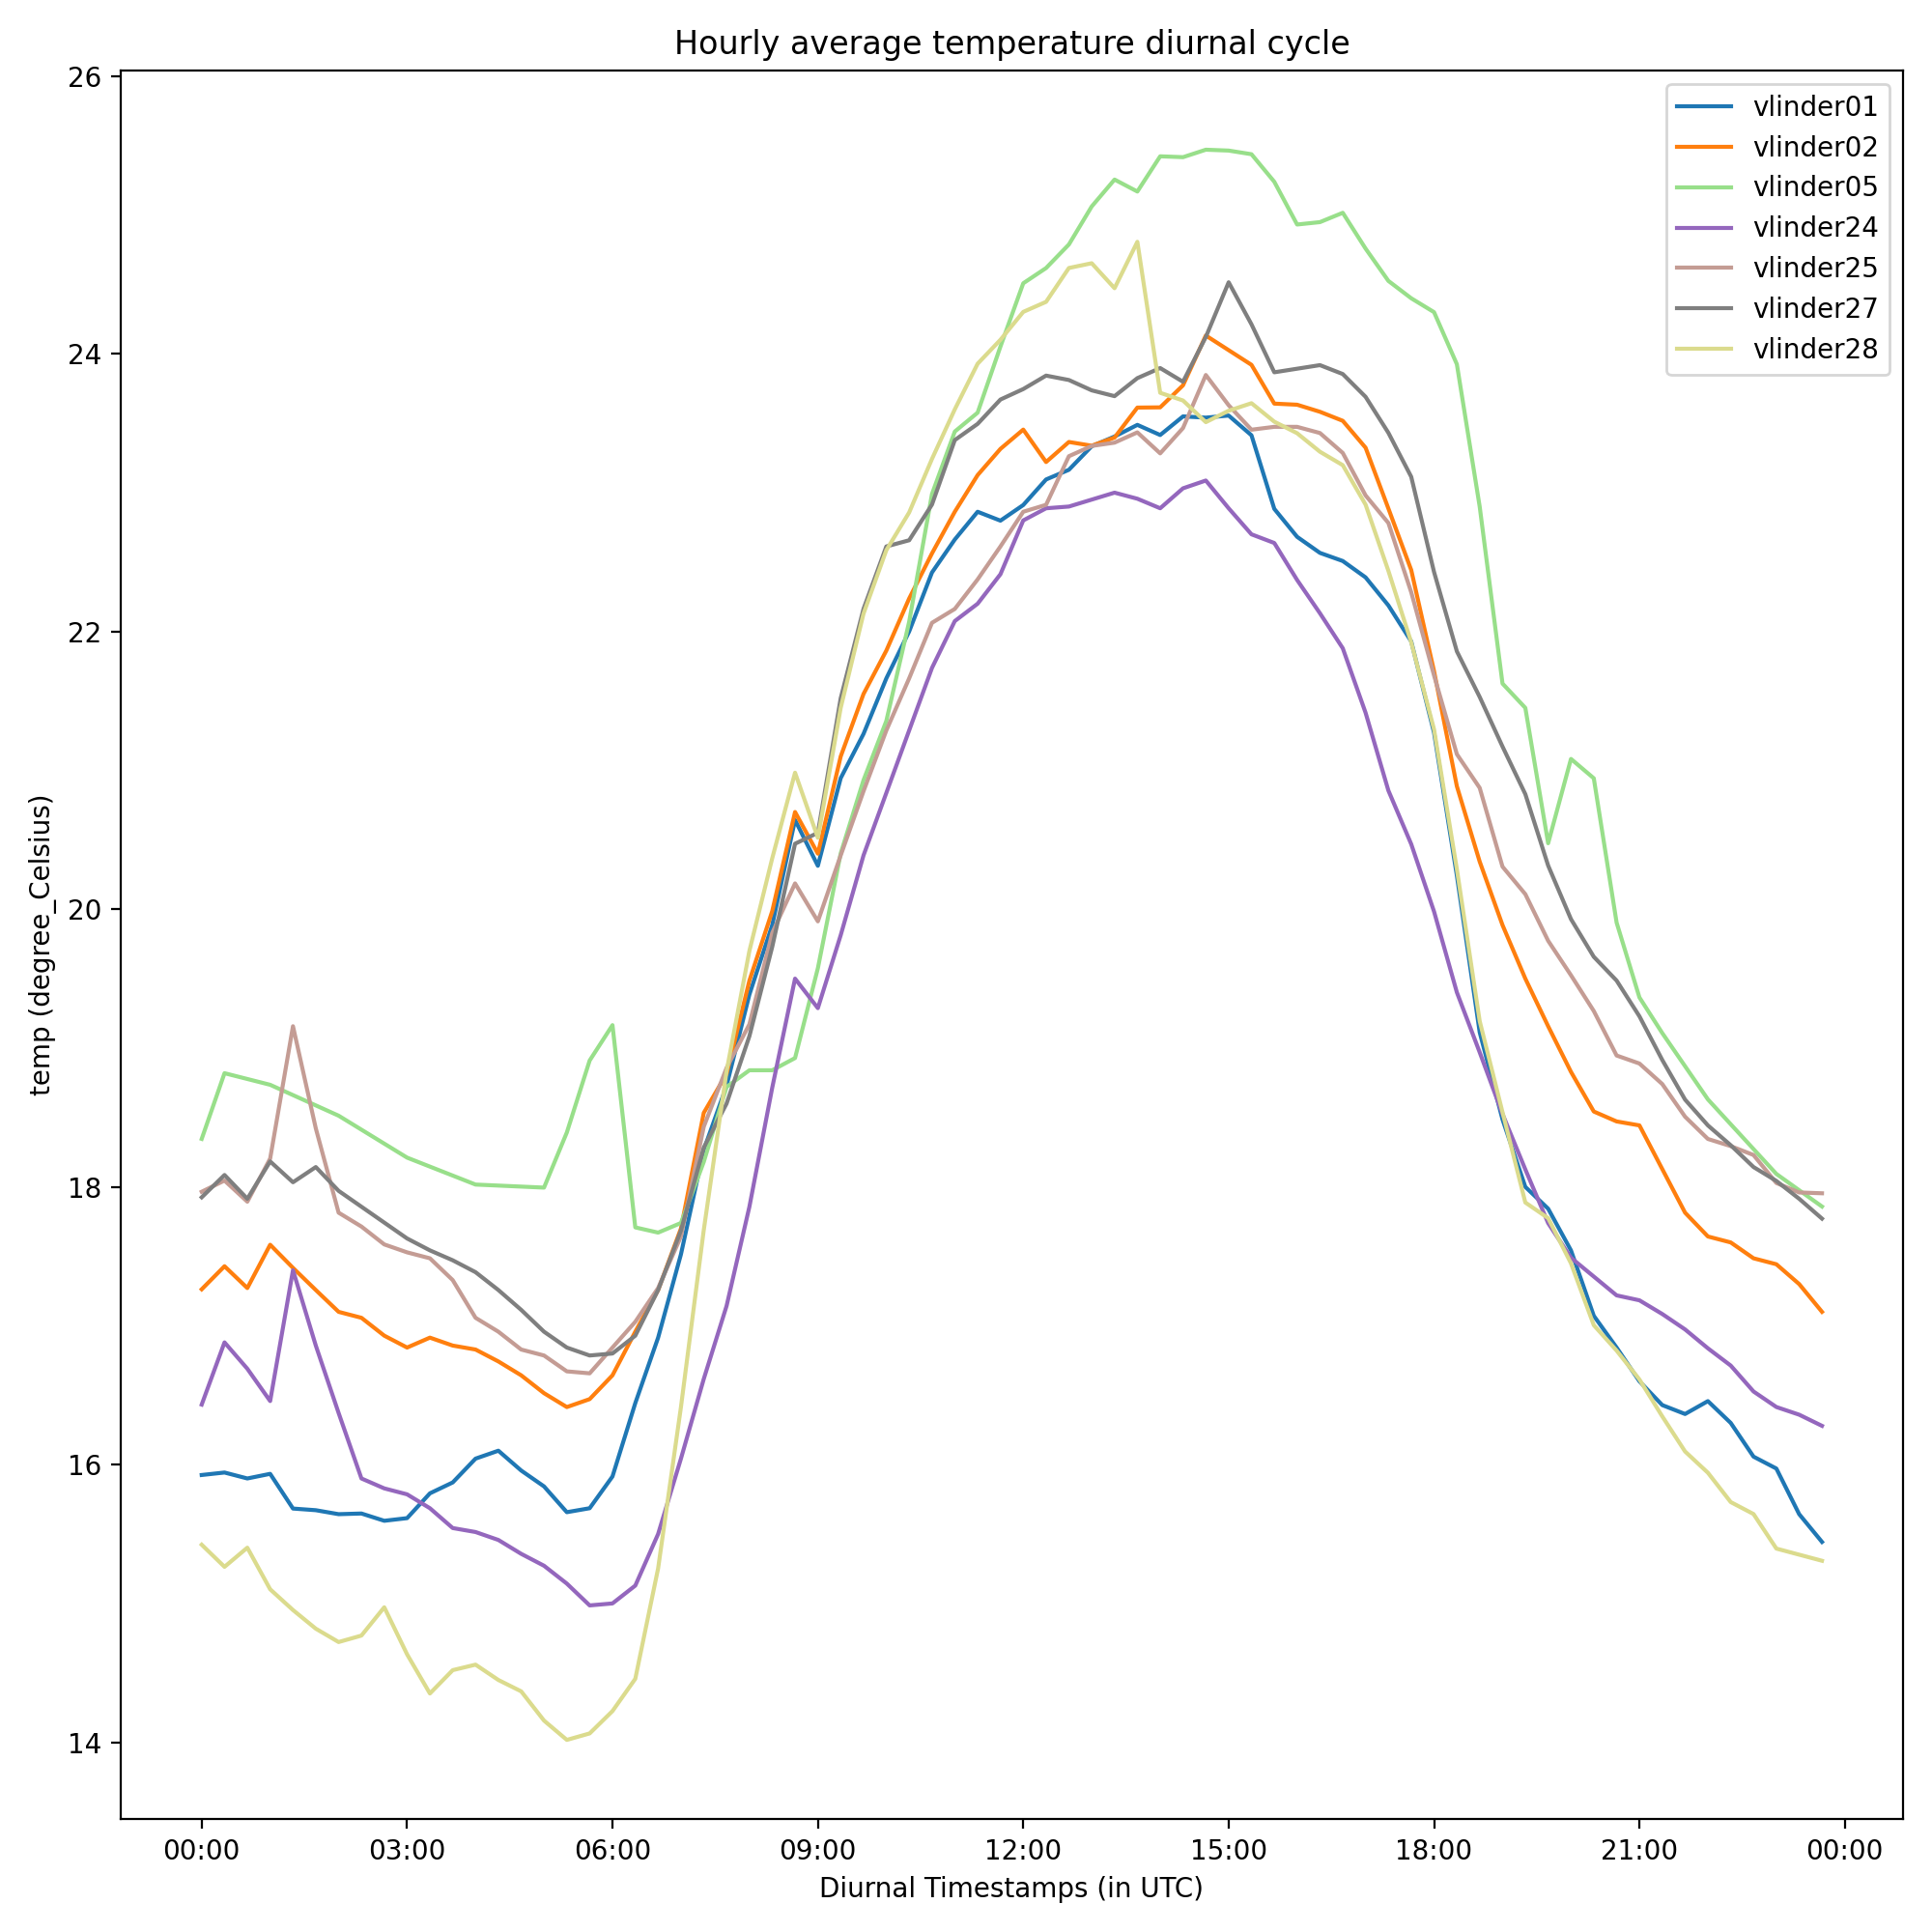

In [8]:

# Get Meta data
dataset.get_landcover_fractions(buffers=[50, 150, 500], aggregate=True)

# Create analysis from the dataset
ana = metobs_toolkit.Analysis(dataset)

# Make diurnal cycle analysis with plot
ax4 = ana.plot_diurnal_cycle(colorby='name',
                            trgobstype='temp',
                            
                            title='Hourly average temperature diurnal cycle',
                            legend=True,
)
                                
                                

fig = plt.gcf()
fig.set_dpi(200)
fig.tight_layout()

plt.show()

## Interactive spatial

In [9]:

geemanager_to_plot = metobs_toolkit.default_GEE_datasets['worldcover']

dataset.make_gee_plot(geedatasetmanager=geemanager_to_plot)